<a href="https://colab.research.google.com/github/hnioua/OCR-Text-Recognition-in-Challenging-Conditions/blob/main/TM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

In [2]:
!pip install rarfile

In [3]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [8]:
import rarfile
import os

# Chemin vers le fichier RAR
rar_path = "testing_data.rar"  # Assure-toi que ce chemin est correct

# Répertoire de destination
extract_dir = "extracted_images"

# Extraire le contenu
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_dir)

In [9]:
with rarfile.RarFile(rar_path) as rf:
    for f in rf.infolist():
        try:
            rf.extract(f, extract_dir)
        except rarfile.BadRarFile as e:
            print(f"Erreur d'extraction pour {f.filename}: {e}")

Attempting to load image: extracted_images/testing_data/E/44366.png
Image loaded successfully with shape: (36, 27)


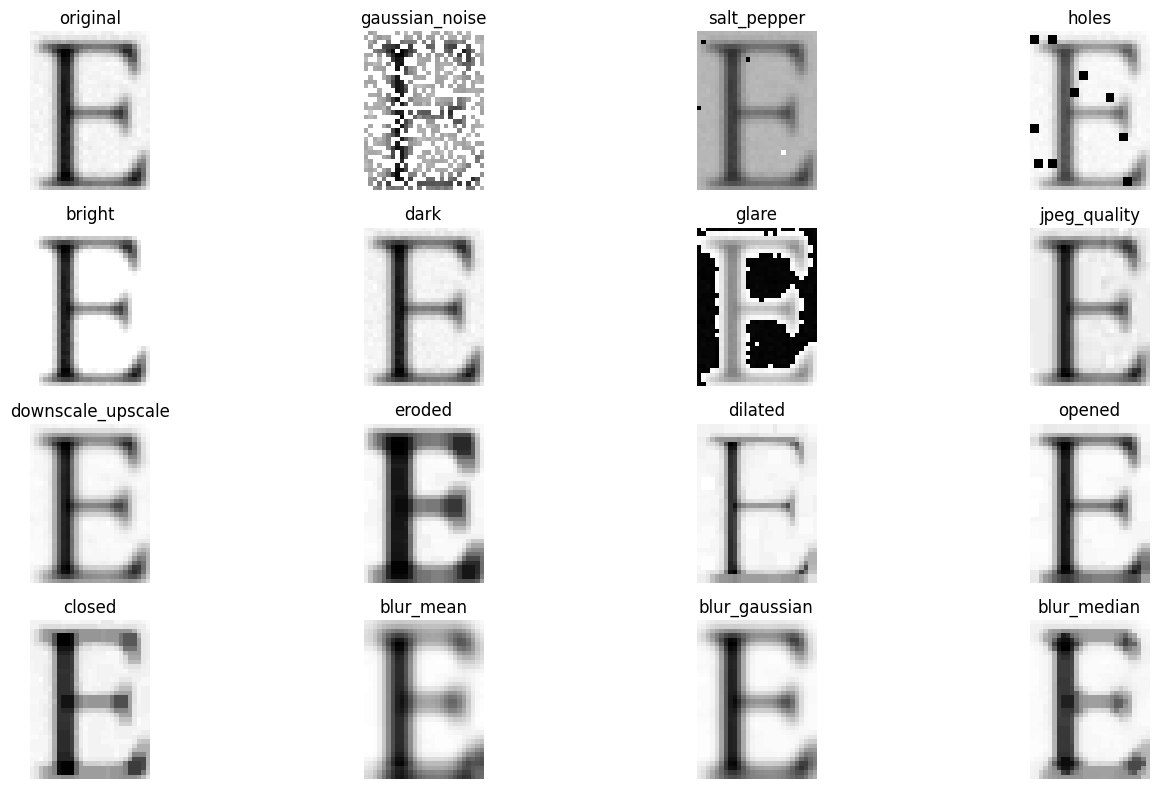

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Charger image en niveaux de gris
img_path = 'extracted_images/testing_data/E/44366.png'  # Changez ce chemin

# Répertoire de sortie
os.makedirs("output", exist_ok=True)

# Attempt to load the image
print(f"Attempting to load image: {img_path}")
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from path: {img_path}")
    print("Please verify the file path and ensure the image exists and is not corrupted.")
else:
    print(f"Image loaded successfully with shape: {img.shape}")
    # ---------------------
    # Fonctions de bruit
    # ---------------------
    def add_gaussian_noise(image, mean=0, sigma=20):
        gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
        noisy = cv2.add(image, gauss)
        return noisy

    def add_salt_pepper_noise(image, amount=0.02):
        noisy = image.copy()
        num_pixels = int(amount * image.size)

        # Select random coordinates
        y_coords = np.random.randint(0, image.shape[0], num_pixels)
        x_coords = np.random.randint(0, image.shape[1], num_pixels)

        # Assign salt (255) or pepper (0) to random locations
        is_salt = np.random.choice([True, False], num_pixels)
        noisy[y_coords[is_salt], x_coords[is_salt]] = 255
        noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0

        return noisy

    def add_holes(image, count=50, size=2):
        img = image.copy()
        h, w = img.shape
        for _ in range(count):
            y = np.random.randint(0, h - size)
            x = np.random.randint(0, w - size)
            img[y:y+size, x:x+size] = 0  # Noir
        return img

    def adjust_brightness(image, factor=1.2):
        return np.clip(image * factor, 0, 255).astype(np.uint8)

    def add_glare(image, center=None, radius=30, intensity=150):
        glare = np.zeros_like(image)
        if center is None:
            center = (image.shape[1]//2, image.shape[0]//2)
        cv2.circle(glare, center, radius, (intensity,), -1)
        glare = cv2.GaussianBlur(glare, (0, 0), radius/2)
        return np.clip(image + glare, 0, 255).astype(np.uint8)

    def reduce_quality(image, quality=30):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', image, encode_param)
        decimg = cv2.imdecode(encimg, 0)
        return decimg

    def downscale_then_upscale(image, scale=0.5):
        h, w = image.shape
        small = cv2.resize(image, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

    # ---------------------
    # Morphologie
    # ---------------------
    def apply_morphology(image, operation='erode', kernel_size=3):
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        if operation == 'erode':
            return cv2.erode(image, kernel, iterations=1)
        elif operation == 'dilate':
            return cv2.dilate(image, kernel, iterations=1)
        elif operation == 'open':
            return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif operation == 'close':
            return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        return image

    # ---------------------
    # Appliquer toutes les transformations
    # ---------------------
    transformations = {
        "original": img,
        "gaussian_noise": add_gaussian_noise(img, sigma=10),
        "salt_pepper": add_salt_pepper_noise(img, amount=0.005),
        "holes": add_holes(img, count=10, size=2),
        "bright": adjust_brightness(img, 1.5),
        "dark": adjust_brightness(img, 0.5),
        "glare": add_glare(img, radius=20, intensity=80),
        "jpeg_quality": reduce_quality(img, quality=60),
        "downscale_upscale": downscale_then_upscale(img, scale=0.8),
        "eroded": apply_morphology(img, 'erode'),
        "dilated": apply_morphology(img, 'dilate'),
        "opened": apply_morphology(img, 'open'),
        "closed": apply_morphology(img, 'close'),
        "blur_mean": cv2.blur(img, (5, 5)),
        "blur_gaussian": cv2.GaussianBlur(img, (5, 5), 0),
        "blur_median": cv2.medianBlur(img, 5),
    }


    # Sauvegarder toutes les images transformées
    for name, transformed in transformations.items():
        out_path = f"output/{name}.png"
        cv2.imwrite(out_path, transformed)

    # Affichage d'exemple
    plt.figure(figsize=(15, 8))
    for i, (name, transformed) in enumerate(transformations.items()):
        plt.subplot(4, 4, i+1)
        plt.imshow(transformed, cmap='gray')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
import os
import pandas as pd

# Dossier racine des images extraites
base_dir = "extracted_images/testing_data"

# Liste pour stocker les données
data = []

# Parcours tous les sous-dossiers (A, B, C, ..., 0, 1, 2, ...)
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        # Parcours toutes les images dans ce dossier
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                data.append({'image': image_path, 'label': folder_name})

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage des premières lignes
print(df.head())

                                       image label
0  extracted_images/testing_data/4/41332.png     4
1  extracted_images/testing_data/4/42844.png     4
2  extracted_images/testing_data/4/43348.png     4
3  extracted_images/testing_data/4/42700.png     4
4  extracted_images/testing_data/4/41440.png     4


In [12]:
df['label'].value_counts()

,count
label,
0,181
4,88
5,88
E,88
9,88
6,88
1,88
D,88
A,88


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Fonctions de transformation
# ---------------------
def add_gaussian_noise(image, mean=0, sigma=20):
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return cv2.add(image, gauss)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_pixels = int(amount * image.size)
    y_coords = np.random.randint(0, image.shape[0], num_pixels)
    x_coords = np.random.randint(0, image.shape[1], num_pixels)
    is_salt = np.random.choice([True, False], num_pixels)
    noisy[y_coords[is_salt], x_coords[is_salt]] = 255
    noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0
    return noisy

def add_holes(image, count=50, size=2):
    img = image.copy()
    h, w = img.shape
    for _ in range(count):
        y = np.random.randint(0, h - size)
        x = np.random.randint(0, w - size)
        img[y:y+size, x:x+size] = 0
    return img

def adjust_brightness(image, factor=1.2):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def add_glare(image, center=None, radius=30, intensity=150):
    glare = np.zeros_like(image)
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.circle(glare, center, radius, (intensity,), -1)
    glare = cv2.GaussianBlur(glare, (0, 0), radius / 2)
    return np.clip(image + glare, 0, 255).astype(np.uint8)

def reduce_quality(image, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, 0)

def downscale_then_upscale(image, scale=0.5):
    h, w = image.shape
    small = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

def apply_morphology(image, operation='erode', kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    if operation == 'erode':
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'dilate':
        return cv2.dilate(image, kernel, iterations=1)
    elif operation == 'open':
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image

# ---------------------
# Dataset
# ---------------------
base_dir = "extracted_images/testing_data"
transformations = {
    "gaussian": lambda img: add_gaussian_noise(img, sigma=10),
    "saltpepper": lambda img: add_salt_pepper_noise(img, amount=0.005),
    "holes": lambda img: add_holes(img, count=10, size=2),
    "bright": lambda img: adjust_brightness(img, 1.5),
    "dark": lambda img: adjust_brightness(img, 0.5),
    "glare": lambda img: add_glare(img, radius=20, intensity=80),
    "jpeg": lambda img: reduce_quality(img, quality=60),
    "resize": lambda img: downscale_then_upscale(img, scale=0.8),
    "erode": lambda img: apply_morphology(img, 'erode'),
    "dilate": lambda img: apply_morphology(img, 'dilate'),
    "open": lambda img: apply_morphology(img, 'open'),
    "close": lambda img: apply_morphology(img, 'close'),
    "blur_mean": lambda img: cv2.blur(img, (5, 5)),
    "blur_gaussian": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "blur_median": lambda img: cv2.medianBlur(img, 5),
}

count = 0

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Sauvegarder les transformations dans le même dossier
            name_base, ext = os.path.splitext(filename)
            for suffix, func in transformations.items():
                transformed = func(img)
                new_filename = f"{name_base}_{suffix}{ext}"
                cv2.imwrite(os.path.join(folder_path, new_filename), transformed)
                count += 1

print(f"✅ Terminé : {count} images transformées et sauvegardées.")


✅ Terminé : 48615 images transformées et sauvegardées.


In [14]:
from collections import defaultdict

# Dictionnaire pour stocker le comptage par label
label_counts = defaultdict(int)

# Extensions d'images à considérer
valid_exts = ('.png', '.jpg', '.jpeg')

# Parcours des dossiers pour compter les images
for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    # Compter les fichiers image dans ce dossier
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

# Affichage
print("\n📊 Nombre d'images par label :")
for label, count in sorted(label_counts.items()):
    print(f" - {label} : {count} images")



📊 Nombre d'images par label :
 - 0 : 2896 images
 - 1 : 1408 images
 - 2 : 1408 images
 - 3 : 1408 images
 - 4 : 1408 images
 - 5 : 1408 images
 - 6 : 1408 images
 - 7 : 1408 images
 - 8 : 1408 images
 - 9 : 1408 images
 - A : 1408 images
 - B : 1408 images
 - C : 1408 images
 - D : 1408 images
 - E : 1408 images
 - F : 1408 images
 - G : 1393 images
 - H : 1392 images
 - I : 1392 images
 - J : 1392 images
 - K : 1392 images
 - L : 1392 images
 - M : 1392 images
 - N : 1392 images
 - O : 1392 images
 - P : 1392 images
 - Q : 1392 images
 - R : 1392 images
 - S : 1392 images
 - T : 1392 images
 - U : 1392 images
 - V : 1392 images
 - W : 1392 images
 - X : 1392 images
 - Y : 1392 images
 - Z : 1392 images



📊 Nombre d'images par label :
 - 0 : 2896 images
 - 1 : 1408 images
 - 2 : 1408 images
 - 3 : 1408 images
 - 4 : 1408 images
 - 5 : 1408 images
 - 6 : 1408 images
 - 7 : 1408 images
 - 8 : 1408 images
 - 9 : 1408 images
 - A : 1408 images
 - B : 1408 images
 - C : 1408 images
 - D : 1408 images
 - E : 1408 images
 - F : 1408 images
 - G : 1393 images
 - H : 1392 images
 - I : 1392 images
 - J : 1392 images
 - K : 1392 images
 - L : 1392 images
 - M : 1392 images
 - N : 1392 images
 - O : 1392 images
 - P : 1392 images
 - Q : 1392 images
 - R : 1392 images
 - S : 1392 images
 - T : 1392 images
 - U : 1392 images
 - V : 1392 images
 - W : 1392 images
 - X : 1392 images
 - Y : 1392 images
 - Z : 1392 images


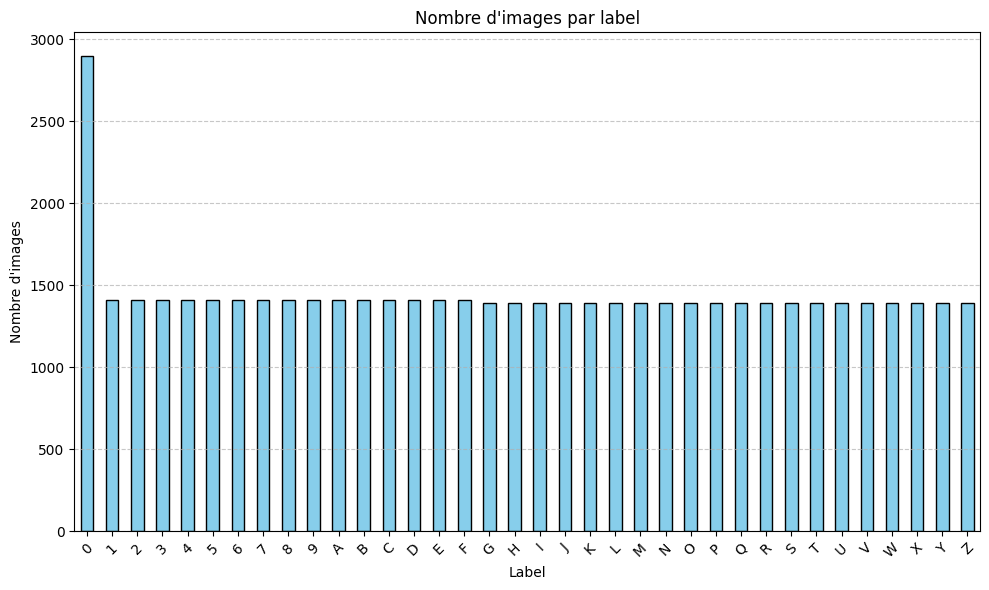

In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import os

# Assume base_dir is defined as in your code
base_dir = "extracted_images/testing_data"

# Assume label_counts is populated as in your code
label_counts = defaultdict(int)
valid_exts = ('.png', '.jpg', '.jpeg')

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

# Convert the defaultdict to a pandas Series
label_series = pd.Series(label_counts)

# Sort the series by index (label) for consistent plotting
label_series = label_series.sort_index()

# ✅ Affichage dans la console
print("\n📊 Nombre d'images par label :")
for label, count in label_series.items():
    print(f" - {label} : {count} images")

# 📈 Graphe en barres
plt.figure(figsize=(10, 6))
label_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'images par label")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
!pip install imbalanced-learn

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

# Dossier racine des images extraites
base_dir = "extracted_images/testing_data"

# Taille cible pour redimensionner les images
TARGET_SIZE = (32, 32) # Exemple : 32x32 pixels

# --- Étape 1 & 2 : Chargement, Prétraitement et Extraction des caractéristiques ---
data = []
labels = []

print("⏳ Chargement et prétraitement des images...")

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Redimensionner l'image
                img_resized = cv2.resize(img, TARGET_SIZE)
                # Aplatir l'image en vecteur
                img_vector = img_resized.flatten()
                data.append(img_vector)
                labels.append(label_folder)

# Convertir en tableaux NumPy
X = np.array(data)
y = np.array(labels)

print(f"✅ Chargement terminé. Forme de X : {X.shape}, Forme de y : {y.shape}")
print(f"Distribution des classes avant SMOTE : {Counter(y)}")

# --- Étape 3 : Application de SMOTE ---
# Initialiser SMOTE
# 'not majority' suréchantillonne toutes les classes sauf la classe majoritaire ('0' dans votre cas)
smote = SMOTE(sampling_strategy='not majority', random_state=42)

print("⏳ Application de SMOTE...")
X_resampled, y_resampled = smote.fit_resample(X, y)

print("✅ SMOTE appliqué.")
print(f"Distribution des classes après SMOTE : {Counter(y_resampled)}")


⏳ Chargement et prétraitement des images...
✅ Chargement terminé. Forme de X : (51856, 1024), Forme de y : (51856,)
Distribution des classes avant SMOTE : Counter({np.str_('0'): 2896, np.str_('4'): 1408, np.str_('E'): 1408, np.str_('5'): 1408, np.str_('D'): 1408, np.str_('1'): 1408, np.str_('A'): 1408, np.str_('7'): 1408, np.str_('C'): 1408, np.str_('B'): 1408, np.str_('3'): 1408, np.str_('F'): 1408, np.str_('2'): 1408, np.str_('9'): 1408, np.str_('8'): 1408, np.str_('6'): 1408, np.str_('U'): 1392, np.str_('M'): 1392, np.str_('Z'): 1392, np.str_('T'): 1392, np.str_('N'): 1392, np.str_('Y'): 1392, np.str_('R'): 1392, np.str_('V'): 1392, np.str_('H'): 1392, np.str_('J'): 1392, np.str_('X'): 1392, np.str_('P'): 1392, np.str_('O'): 1392, np.str_('S'): 1392, np.str_('I'): 1392, np.str_('L'): 1392, np.str_('W'): 1392, np.str_('Q'): 1392, np.str_('G'): 1392, np.str_('K'): 1392})
⏳ Application de SMOTE...
✅ SMOTE appliqué.
Distribution des classes après SMOTE : Counter({np.str_('4'): 2896, np.

⏳ Chargement et prétraitement des images...
Distribution des classes avant SMOTE : Counter({np.str_('0'): 2896, np.str_('4'): 1408, np.str_('E'): 1408, np.str_('5'): 1408, np.str_('D'): 1408, np.str_('1'): 1408, np.str_('A'): 1408, np.str_('7'): 1408, np.str_('C'): 1408, np.str_('B'): 1408, np.str_('3'): 1408, np.str_('F'): 1408, np.str_('2'): 1408, np.str_('9'): 1408, np.str_('8'): 1408, np.str_('6'): 1408, np.str_('U'): 1392, np.str_('M'): 1392, np.str_('Z'): 1392, np.str_('T'): 1392, np.str_('N'): 1392, np.str_('Y'): 1392, np.str_('R'): 1392, np.str_('V'): 1392, np.str_('H'): 1392, np.str_('J'): 1392, np.str_('X'): 1392, np.str_('P'): 1392, np.str_('O'): 1392, np.str_('S'): 1392, np.str_('I'): 1392, np.str_('L'): 1392, np.str_('W'): 1392, np.str_('Q'): 1392, np.str_('G'): 1392, np.str_('K'): 1392})
⏳ Application de SMOTE...
✅ SMOTE appliqué.

Distribution des classes après SMOTE : Counter({np.str_('4'): 2896, np.str_('U'): 2896, np.str_('M'): 2896, np.str_('E'): 2896, np.str_('5'): 

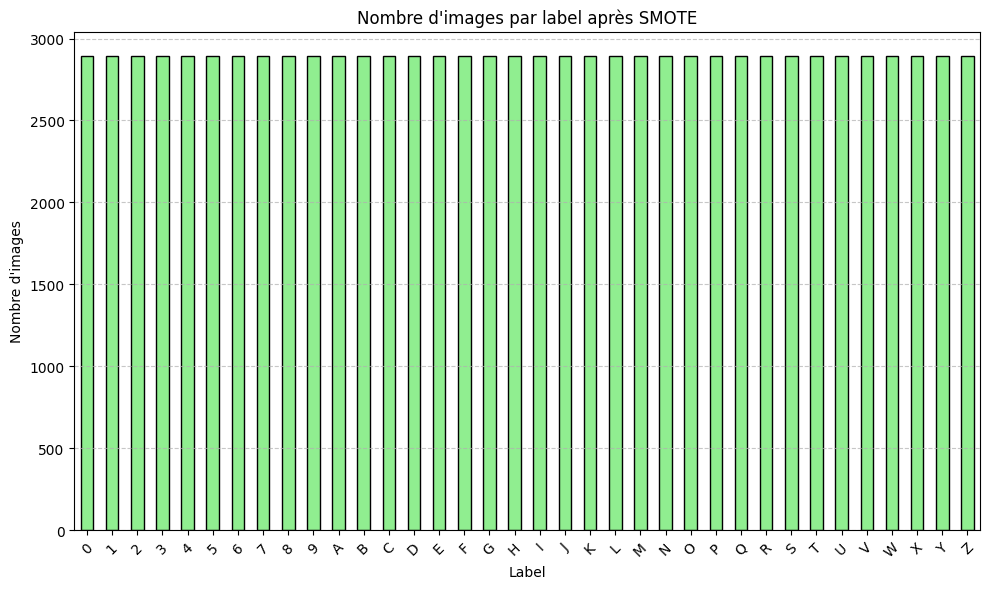

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# --- Code d'Oversampling (assurez-vous de l'avoir exécuté) ---
# Dossier racine des images extraites
base_dir = "extracted_images/testing_data"
TARGET_SIZE = (32, 32)

data = []
labels = []

print("⏳ Chargement et prétraitement des images...")
for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, TARGET_SIZE)
                img_vector = img_resized.flatten()
                data.append(img_vector)
                labels.append(label_folder)

X = np.array(data)
y = np.array(labels)

print(f"Distribution des classes avant SMOTE : {Counter(y)}")

smote = SMOTE(sampling_strategy='not majority', random_state=42)
print("⏳ Application de SMOTE...")
X_resampled, y_resampled = smote.fit_resample(X, y)
print("✅ SMOTE appliqué.")
# --- Fin du code d'Oversampling ---


# --- Visualisation après Oversampling ---
print(f"\nDistribution des classes après SMOTE : {Counter(y_resampled)}")

# Convertir la distribution après SMOTE en pandas Series pour le graphique
label_counts_resampled = Counter(y_resampled)
label_series_resampled = pd.Series(label_counts_resampled)

# Sort the series by index (label) for consistent plotting
label_series_resampled = label_series_resampled.sort_index()

# 📈 Graphe en barres
plt.figure(figsize=(10, 6))
label_series_resampled.plot(kind='bar', color='lightgreen', edgecolor='black') # Utiliser une couleur différente
plt.title("Nombre d'images par label après SMOTE")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Affichage d'exemples d'images par label :


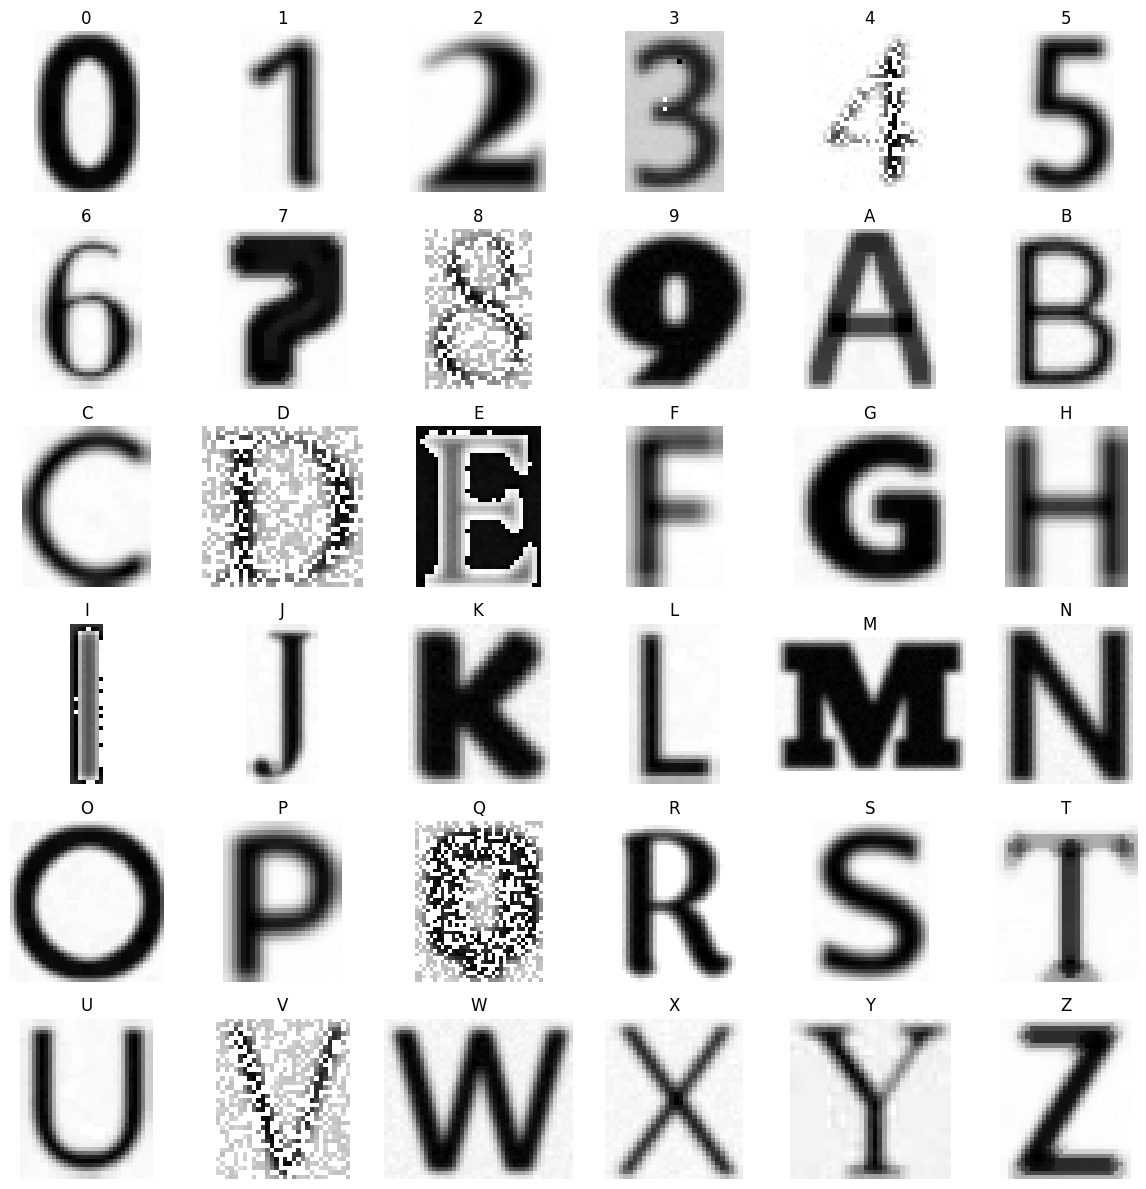

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
import random # Pour choisir une image aléatoirement par label

# Dossier racine des images extraites
base_dir = "extracted_images/testing_data"

# Nombre d'exemples à afficher par label (vous pouvez ajuster)
NUM_EXAMPLES_PER_LABEL = 1

print("\nAffichage d'exemples d'images par label :")

# Obtenir la liste de tous les dossiers (labels)
label_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
label_folders.sort() # Tri alphabétique pour un affichage ordonné

# Configuration pour l'affichage des images
num_labels = len(label_folders)
# Calculer le nombre de lignes et de colonnes pour le sous-graphique
# sqrt(num_labels) donne une idée de la disposition
cols = int(np.ceil(np.sqrt(num_labels)))
rows = int(np.ceil(num_labels / cols))

plt.figure(figsize=(cols * 2, rows * 2)) # Ajustez la taille de la figure si nécessaire

for i, label_folder in enumerate(label_folders):
    folder_path = os.path.join(base_dir, label_folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        # Choisir une ou plusieurs images aléatoirement
        selected_images = random.sample(image_files, min(NUM_EXAMPLES_PER_LABEL, len(image_files)))

        for j, filename in enumerate(selected_images):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Afficher l'image dans un sous-graphique
                # Le calcul de l'index du sous-graphique dépend du nombre d'exemples par label
                # Ici, nous affichons un seul exemple par label, donc index = i + 1
                plt.subplot(rows, cols, i + 1)
                plt.imshow(img, cmap='gray')
                plt.title(label_folder)
                plt.axis('off') # Masquer les axes

plt.tight_layout() # Ajuster l'espacement entre les sous-graphiques
plt.show()

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming X_resampled and y_resampled are already defined from the previous steps
# ...

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Forme de X_train : {X_train.shape}, Forme de y_train : {y_train.shape}")
print(f"Forme de X_test : {X_test.shape}, Forme de y_test : {y_test.shape}")

# Convert NumPy arrays to pandas DataFrames (for X) and Series (for y)
X_train_df = pd.DataFrame(X_train)
y_train_series = pd.Series(y_train, name='label') # Name the Series for clarity

X_test_df = pd.DataFrame(X_test)
y_test_series = pd.Series(y_test, name='label') # Name the Series for clarity


# Concatenate to create the training and testing DataFrames
# Use ignore_index=True to reset the index after concatenation
training_df = pd.concat([X_train_df, y_train_series], axis=1, ignore_index=True)
testing_df = pd.concat([X_test_df, y_test_series], axis=1, ignore_index=True)

print("\nCreated training_df and testing_df:")
print("training_df head:")
print(training_df.head())
print("\ntesting_df head:")
print(testing_df.head())

Forme de X_train : (83404, 1024), Forme de y_train : (83404,)
Forme de X_test : (20852, 1024), Forme de y_test : (20852,)

Created training_df and testing_df:
training_df head:
   0     1     2     3     4     5     6     7     8     9     ...  1015  \
0   202   206   202   199   195   190   189   191   190   191  ...   149   
1   182   183   174   174   173   182   182   173   173   171  ...   115   
2   255   255   255   253   255   241   212   242   243   229  ...   250   
3   212   212   212   212   212   212   212   213   213   212  ...   212   
4   255   255   255   255   252   251   250   250   250   250  ...   192   

   1016  1017  1018  1019  1020  1021  1022  1023  1024  
0   152   149   150   155   163   174   190   204     Z  
1   115   115   116   118   125   135   146   154     2  
2   237   235   192   232   241   249   243   254     M  
3   212   212   212   212   212   212   212   213     5  
4   191   192   193   196   203   218   236   253     E  

[5 rows x 1025 co

In [ ]:
# # Splitting for training & testing (70,30 respectively)
# X, y = df['image'], df['label']
# X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
# training_df = pd.concat((X_train,y_train), axis=1)
# testing_df = pd.concat((X_test,y_test), axis=1)


📊 Nombre d'images par label dans l'ensemble d'entraînement (y_train) :


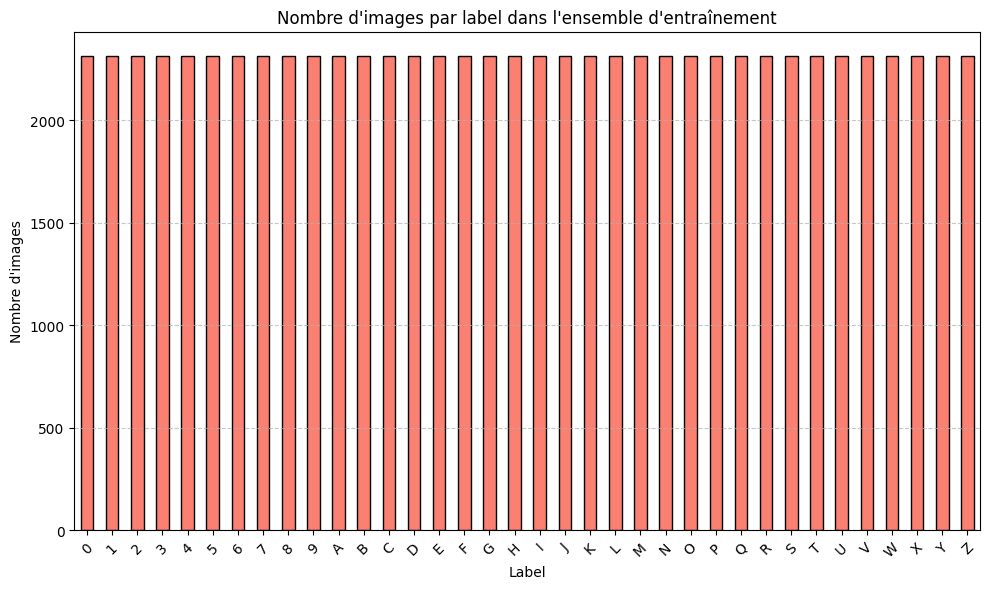

In [21]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# --- Code from previous cells (assuming it's already executed) ---
# X_resampled, y_resampled are available
# X_train, X_test, y_train, y_test are available after train_test_split
# --- End of code from previous cells ---


# --- Visualisation du nombre de labels dans y_train ---
print("\n📊 Nombre d'images par label dans l'ensemble d'entraînement (y_train) :")

# Compter la distribution des labels dans y_train
train_label_counts = Counter(y_train)


# Convertir en pandas Series pour le graphique
train_label_series = pd.Series(train_label_counts)

# Sort the series by index (label) for consistent plotting
train_label_series = train_label_series.sort_index()

# 📈 Graphe en barres
plt.figure(figsize=(10, 6))
train_label_series.plot(kind='bar', color='salmon', edgecolor='black') # Utiliser une couleur différente
plt.title("Nombre d'images par label dans l'ensemble d'entraînement")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# Assuming X_train, X_test, y_train, y_test are defined from previous steps
# and TARGET_SIZE is defined (e.g., TARGET_SIZE = (32, 32))

# --- Step 1: Standardize the data ---
# Scale pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("✅ Data standardized.")

# --- Step 2: Prepare the data for CNN ---
# Reshape data to (num_samples, height, width, channels)
# Assuming images are grayscale, channels = 1
img_height, img_width = TARGET_SIZE
X_train = X_train.reshape(-1, img_height, img_width, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

print(f"✅ Data reshaped for CNN. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

print(f"✅ Labels one-hot encoded. y_train_one_hot shape: {y_train_one_hot.shape}, y_test_one_hot shape: {y_test_one_hot.shape}")

# --- Step 3: Build a powerful CNN model (using Transfer Learning with MobileNetV2 example) ---
# You can choose another model like EfficientNetB7, VGG19, DenseNet121
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# MobileNetV2 expects 3 channels, so we need to handle grayscale images
# You can convert grayscale to 3 channels by duplicating the channel
X_train_3_channels = np.repeat(X_train, 3, axis=-1)
X_test_3_channels = np.repeat(X_test, 3, axis=-1)

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Use GlobalAveragePooling2D instead of Flatten
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') # Output layer for classification
])

print("✅ CNN model built using MobileNetV2.")


✅ Data standardized.
✅ Data reshaped for CNN. X_train shape: (83404, 32, 32, 1), X_test shape: (20852, 32, 32, 1)
✅ Labels one-hot encoded. y_train_one_hot shape: (83404, 36), y_test_one_hot shape: (20852, 36)


<ipython-input-22-71c9b2173c90>:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ CNN model built using MobileNetV2.


In [26]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [29]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

def build_model(hp):
    base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                             include_top=False, weights='imagenet')
    base_model.trainable = hp.Boolean('fine_tune', default=False)

    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='mobilenetv2_opt'
)

tuner.search(X_train_3_channels, y_train_one_hot,
             epochs=5,
             batch_size=32,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Trial 2 Complete [00h 32m 26s]
val_accuracy: 0.9570169448852539

Best val_accuracy So Far: 0.9570169448852539
Total elapsed time: 01h 05m 21s


In [30]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("✅ Meilleurs hyperparamètres trouvés :", best_hyperparameters.values)

<ipython-input-29-1297015a364f>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


✅ Meilleurs hyperparamètres trouvés : {'fine_tune': True, 'dense_units': 192, 'dropout_rate': 0.5, 'lr': 0.0005}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# --- Your build_model and tuner setup code (assuming it's the same) ---
# You can copy the previous code cell that defines build_model and tuner.
# For completeness, including it here as a placeholder:
# import keras_tuner as kt
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.applications import MobileNetV2

# def build_model(hp):
#     base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
#                              include_top=False, weights='imagenet')
#     base_model.trainable = hp.Boolean('fine_tune', default=False)

#     model = tf.keras.Sequential()
#     model.add(base_model)
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
#     model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])))
#     model.add(Dense(len(label_encoder.classes_), activation='softmax'))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])
#         ),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=2,  # Keep this small for a quick example
#     executions_per_trial=1,
#     overwrite=True,
#     directory='tuner_dir',
#     project_name='mobilenetv2_opt'
# )

# # Assuming X_train_3_channels, y_train_one_hot, img_height, img_width,
# # and label_encoder are defined from previous steps.
# tuner.search(X_train_3_channels, y_train_one_hot,
#              epochs=5,
#              batch_size=32,
#              validation_split=0.2,
#              callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# --- Code to extract and plot results ---

# Get the trial results
# Use get_best_trials or access via tuner.oracle.trials depending on Keras Tuner version
# Let's use get_best_trials for compatibility with recent versions
tuner_results = tuner.oracle.get_best_trials(num_models=100) # Get a sufficient number of best trials

# Create a DataFrame from the trial results
results = []
for trial in tuner_results:
    trial_data = trial.hyperparameters.values.copy()
    trial_data['val_accuracy'] = trial.metrics.get_last_value('val_accuracy')
    results.append(trial_data)

df = pd.DataFrame(results)

# --- Afficher graphiquement Impact des hyperparamètres sur la précision ---

# Graphique : Impact des hyperparamètres sur la précision (Dense Units and Dropout)
if 'dropout_rate' in df.columns and 'dense_units' in df.columns and 'val_accuracy' in df.columns:
    plt.figure(figsize=(10, 6))
    for dropout in df['dropout_rate'].unique():
        subset = df[df['dropout_rate'] == dropout]
        # Check if subset is not empty before plotting
        if not subset.empty:
            plt.plot(subset['dense_units'], subset['val_accuracy'], marker='o', label=f'Dropout {dropout}')

    plt.xlabel('Nombre d\'unités dans la couche Dense')
    plt.ylabel('Précision de Validation')
    plt.title('Impact des unités Dense et du Dropout sur la précision')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Impossible de générer le graphique d'impact des hyperparamètres. Vérifiez que les colonnes 'dropout_rate', 'dense_units' et 'val_accuracy' existent dans le DataFrame des résultats du tuner.")

# --- Afficher graphiquement Learning Rate vs Validation Accuracy ---

# Graphique : Learning Rate vs Validation Accuracy
if 'lr' in df.columns and 'val_accuracy' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df['lr'], df['val_accuracy'], c='orange', s=100)
    plt.xscale('log') # Utiliser une échelle logarithmique pour le taux d'apprentissage
    plt.xlabel('Taux d\'apprentissage (Learning Rate)')
    plt.ylabel('Précision de Validation')
    plt.title('Taux d\'apprentissage vs Précision de Validation')
    plt.grid(True)
    plt.show()
else:
    print("Impossible de générer le graphique du Learning Rate vs Précision de Validation. Vérifiez que les colonnes 'lr' et 'val_accuracy' existent dans le DataFrame des résultats du tuner.")

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2

# Assuming X_train_3_channels, y_train_one_hot, X_test_3_channels, y_test_one_hot,
# img_height, img_width, and label_encoder are defined from previous steps.
# Also assuming best_hyperparameters is available from the Keras Tuner step.

# --- Get the best hyperparameters ---
best_hps = best_hyperparameters.values
fine_tune = best_hps['fine_tune']
dense_units = best_hps['dense_units']
dropout_rate = best_hps['dropout_rate']
learning_rate = best_hps['lr']

print(f"⏳ Entraînement du modèle final avec les meilleurs hyperparamètres :")
print(f"  fine_tune: {fine_tune}")
print(f"  dense_units: {dense_units}")
print(f"  dropout_rate: {dropout_rate}")
print(f"  learning_rate: {learning_rate}")

# --- Build the final model with the best hyperparameters ---
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False, weights='imagenet')

# Set trainability of the base model based on the best hyperparameter
base_model.trainable = fine_tune

final_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(dense_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the final model with the best learning rate
final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("✅ Modèle final construit et compilé.")

# Define callbacks (can be the same as before or adjusted)
# Using a longer patience for early stopping for potentially better convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('final_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.0001)


# --- Train the final model ---
print("\n⏳ Entraînement du modèle final...")
history_final = final_model.fit(X_train_3_channels, y_train_one_hot,
                                epochs=10, # Increased epochs for potentially better results
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[early_stopping, model_checkpoint, reduce_lr])

print("✅ Entraînement du modèle final terminé.")



⏳ Entraînement du modèle final avec les meilleurs hyperparamètres :
  fine_tune: True
  dense_units: 192
  dropout_rate: 0.5
  learning_rate: 0.0005


<ipython-input-36-df076bbe85c0>:30: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


✅ Modèle final construit et compilé.

⏳ Entraînement du modèle final...
Epoch 1/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5764 - loss: 1.6481

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 444s 182ms/step - accuracy: 0.5765 - loss: 1.6478 - val_accuracy: 0.8881 - val_loss: 0.4396 - learning_rate: 5.0000e-04
Epoch 2/10
2085/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8983 - loss: 0.3799

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 387s 185ms/step - accuracy: 0.8984 - loss: 0.3798 - val_accuracy: 0.9540 - val_loss: 0.2019 - learning_rate: 5.0000e-04
Epoch 3/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 431s 180ms/step - accuracy: 0.9184 - loss: 0.3069 - val_accuracy: 0.9419 - val_loss: 0.2296 - learning_rate: 5.0000e-04
Epoch 4/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 376s 180ms/step - accuracy: 0.9396 - loss: 0.2302 - val_accuracy: 0.9206 - val_loss: 0.3474 - learning_rate: 5.0000e-04
Epoch 5/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 381s 180ms/step - accuracy: 0.9411 - loss: 0.2210 - val_accuracy: 0.9070 - val_loss: 0.3968 - learning_rate: 5.0000e-04
Epoch 6/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 381s 179ms/step - accuracy: 0.9503 - loss: 0.1877 - val_accuracy: 0.9454 - val_loss: 0.2497 - learning_rate: 5.0000e-04
Epoch 7/10
2085/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9537 - loss: 0.1737

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 389s 182ms/step - accuracy: 0.9537 - loss: 0.1737 - val_accuracy: 0.9670 - val_loss: 0.1341 - learning_rate: 5.0000e-04
Epoch 8/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 374s 179ms/step - accuracy: 0.9583 - loss: 0.1523 - val_accuracy: 0.9609 - val_loss: 0.1699 - learning_rate: 5.0000e-04
Epoch 9/10
2085/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9614 - loss: 0.1420

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 390s 183ms/step - accuracy: 0.9614 - loss: 0.1420 - val_accuracy: 0.9719 - val_loss: 0.1090 - learning_rate: 5.0000e-04
Epoch 10/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 382s 183ms/step - accuracy: 0.9627 - loss: 0.1398 - val_accuracy: 0.9390 - val_loss: 0.3130 - learning_rate: 5.0000e-04
✅ Entraînement du modèle final terminé.

⏳ Évaluation du modèle final...
652/652 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9659 - loss: 0.1249
✅ Perte du Test final : 0.1200
✅ Précision du Test final : 0.9668


In [39]:
# --- Evaluate the final model ---
print("\n⏳ Évaluation du modèle final...")
loss_final, accuracy_final = final_model.evaluate(X_test_3_channels, y_test_one_hot)
print(f"✅ Perte du Test final : {loss_final:.4f}")
print(f"✅ Précision du Test final : {accuracy_final:.4f}")


⏳ Évaluation du modèle final...
652/652 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9659 - loss: 0.1249
✅ Perte du Test final : 0.1200
✅ Précision du Test final : 0.9668


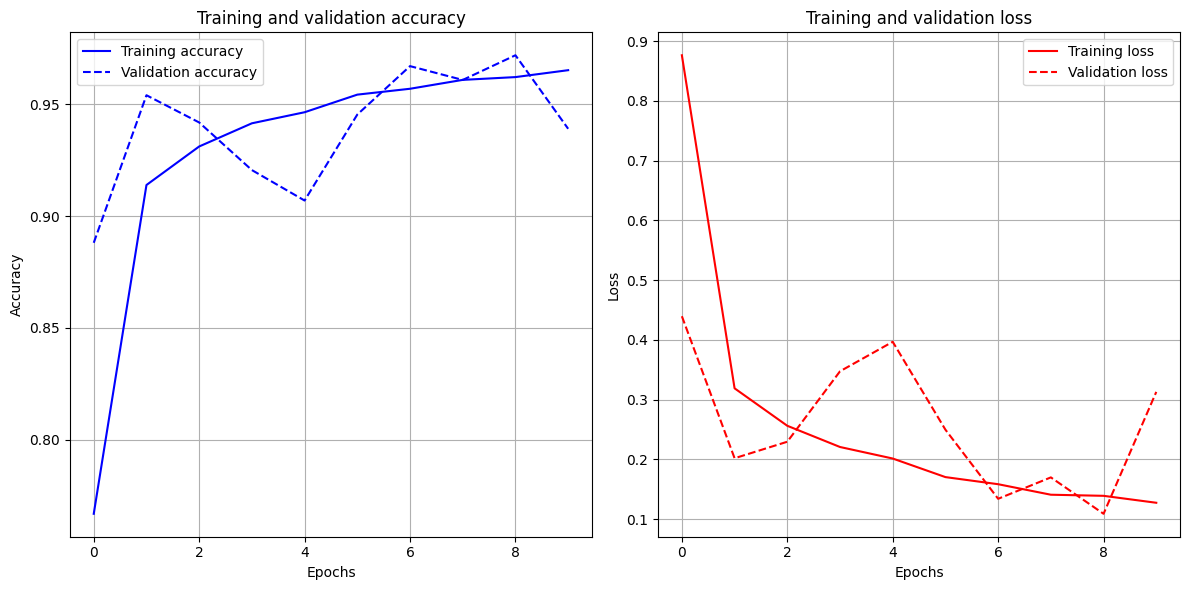

In [83]:
import matplotlib.pyplot as plt

# Assuming 'history_final' object is available from the final_model.fit() call
# (This was generated in the code block where you trained the final model with best HPs)

# Get the training and validation accuracy from the history object
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

# Get the training and validation loss from the history object
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

# Get the number of epochs
epochs = range(len(acc))

# Plot the accuracy curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Create the first subplot for accuracy
# Changed 'bo' to 'b-' for blue line
plt.plot(epochs, acc, 'b-', label='Training accuracy')
# Changed 'b' to 'b--' for dashed blue line
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot the loss curves
plt.subplot(1, 2, 2) # Create the second subplot for loss
# Changed 'ro' to 'r-' for red line
plt.plot(epochs, loss, 'r-', label='Training loss')
# Changed 'r' to 'r--' for dashed red line
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming X_test_3_channels, y_test_one_hot, and final_model are defined from previous steps.
# Also assuming label_encoder is available to get the class names.

# --- Make predictions on the test set ---
print("\n⏳ Génération des prédictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Convert one-hot encoded predictions and true labels back to class indices
y_pred_classes = np.argmax(y_pred_one_hot, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

print("✅ Prédictions générées.")

# --- Compute the confusion matrix ---
# Ensure label_encoder is fitted on the complete set of labels if necessary
# (It should be if you used it to encode y_train before)
class_names = label_encoder.classes_

cm = confusion_matrix(y_true_classes, y_pred_classes)

print("\n✅ Matrice de confusion calculée.")


⏳ Génération des prédictions sur l'ensemble de test...
652/652 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step
✅ Prédictions générées.

✅ Matrice de confusion calculée.


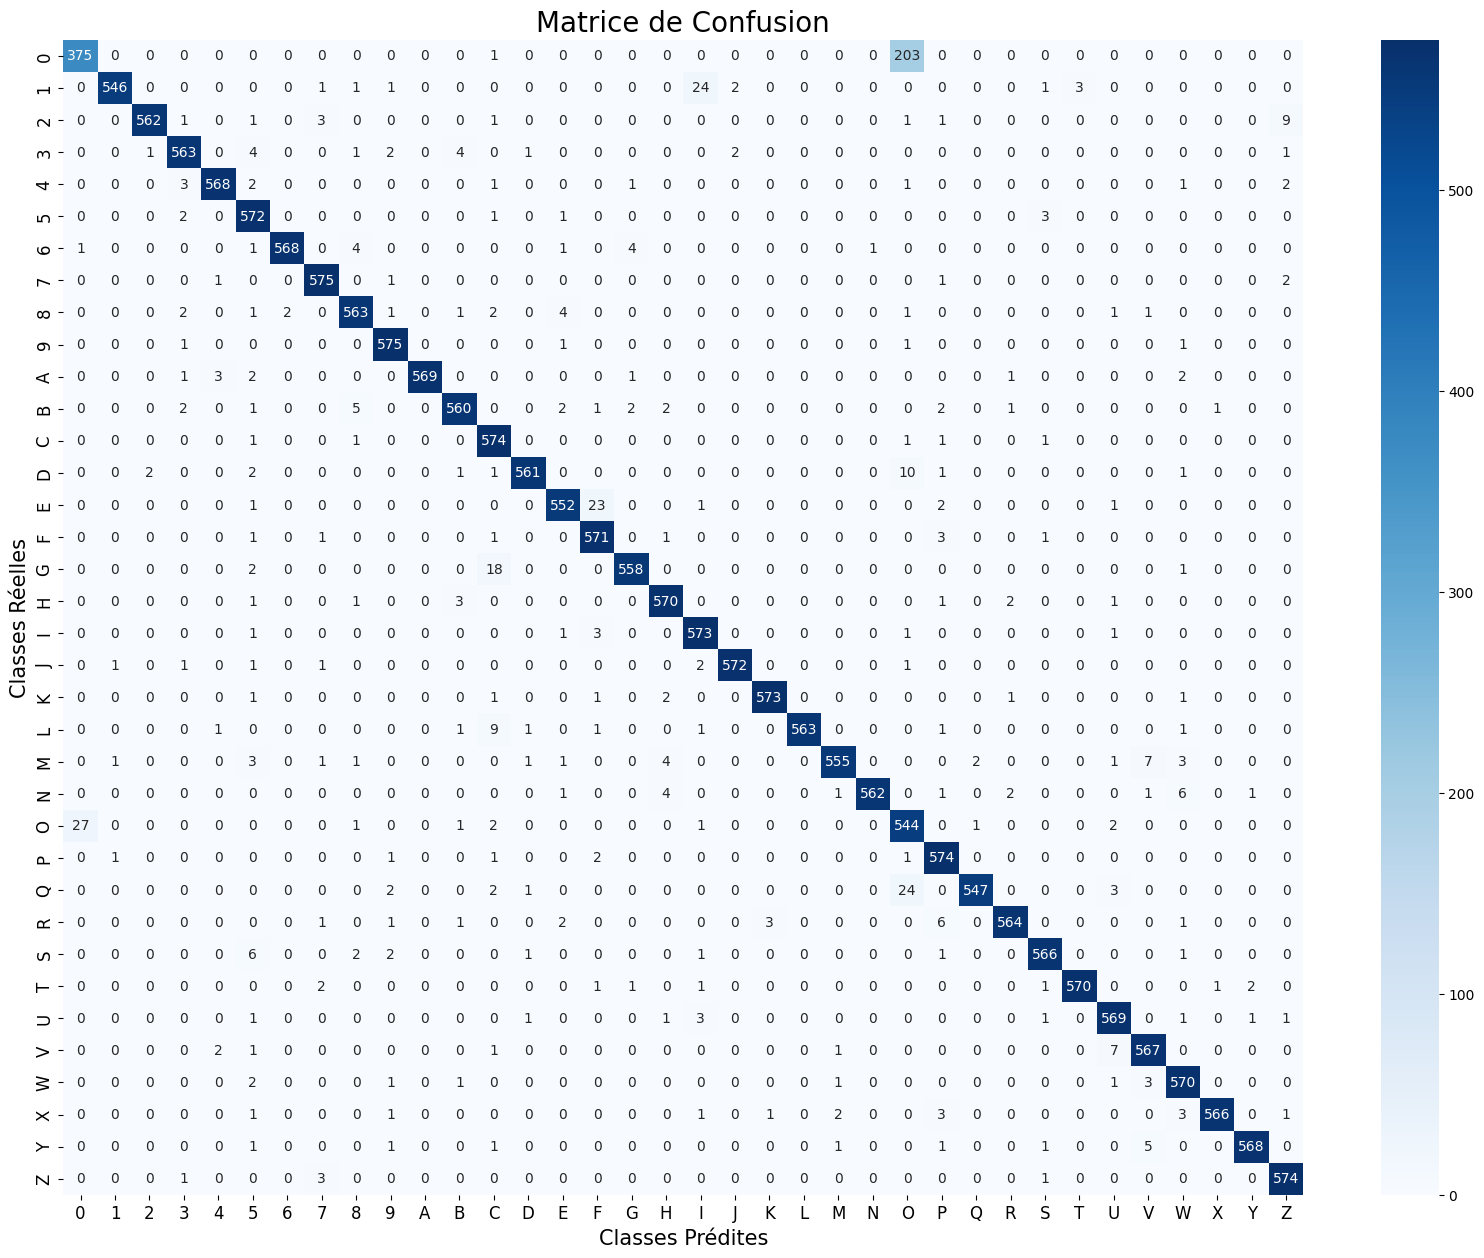


✅ Matrice de confusion affichée.


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # Ensure confusion_matrix is imported if not already

# Assuming cm and class_names are defined from previous steps

# --- Plot the confusion matrix ---
# Increase the figure size for a larger plot
plt.figure(figsize=(20, 15)) # Increased width to 20 and height to 15 (you can adjust these values)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion', fontsize=20) # Optional: Increase title font size
plt.xlabel('Classes Prédites', fontsize=15) # Optional: Increase x-label font size
plt.ylabel('Classes Réelles', fontsize=15) # Optional: Increase y-label font size
plt.xticks(fontsize=12) # Optional: Increase x-tick font size
plt.yticks(fontsize=12) # Optional: Increase y-tick font size
plt.show()

print("\n✅ Matrice de confusion affichée.")

In [44]:
def extract(image, model, mapping_inverse):
    chars = []
    image_cpy = image.copy()

    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)

    for word in words:
        x, y, w, h = word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)

        for char in char_parts:
            x, y, w, h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)
            resized = cv2.resize(ch, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3+22, 3:3+16, 0] = gray.copy()

            rgb_img = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            rgb_img = rgb_img.astype(np.int32)

            pred = model.predict(np.array([rgb_img]), verbose=0)
            predicted_char = mapping_inverse[np.argmax(pred)]
            chars.append(predicted_char)

        chars.append(' ')  # espace entre mots

    return ''.join(chars[:-1])  # retirer le dernier espace


In [56]:
import pandas as pd
import numpy as np

# Assuming X_test_3_channels, y_test_one_hot, final_model, and label_encoder
# are defined from previous steps.

# --- Make predictions on the test set ---
print("\n⏳ Génération des prédictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Convert one-hot encoded predictions and true labels back to class names
y_pred_classes_indices = np.argmax(y_pred_one_hot, axis=1)
y_true_classes_indices = np.argmax(y_test_one_hot, axis=1)

# Map indices back to original labels
y_pred_labels = [label_encoder.classes_[i] for i in y_pred_classes_indices]
y_true_labels = [label_encoder.classes_[i] for i in y_true_classes_indices]

print("✅ Prédictions générées et converties en labels.")

# --- Create a DataFrame to display results ---
results_df = pd.DataFrame({
    'True_Label': y_true_labels,
    'Predicted_Label': y_pred_labels
})

# Optionally, add a column indicating if the prediction was correct
results_df['Is_Correct'] = results_df['True_Label'] == results_df['Predicted_Label']

print("\n📊 Résultats du test sur l'ensemble de test :")
# Display the first few rows of the DataFrame
print(results_df.head())

# You can also display more rows or the entire DataFrame if needed
# print(results_df)

# Optional: Display summary statistics
print("\nRésumé des résultats :")
print(results_df['Is_Correct'].value_counts())


⏳ Génération des prédictions sur l'ensemble de test...
652/652 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step
✅ Prédictions générées et converties en labels.

📊 Résultats du test sur l'ensemble de test :
  True_Label Predicted_Label  Is_Correct
0          L               L        True
1          B               B        True
2          G               G        True
3          0               0        True
4          F               F        True

Résumé des résultats :
Is_Correct
True     20159
False      693
Name: count, dtype: int64


In [52]:
# Assuming final_model is the trained model object

# Define the path where you want to save the model
model_save_path = 'final_trained_model.h5'

# Save the entire model (architecture, weights, and optimizer state)
print(f"⏳ Sauvegarde du modèle entraîné vers {model_save_path}...")
final_model.save(model_save_path)
print("✅ Modèle sauvegardé avec succès.")

# Optional: Verify the saved file exists
import os
if os.path.exists(model_save_path):
    print(f"Le fichier modèle '{model_save_path}' a bien été créé.")
else:
    print(f"Erreur lors de la sauvegarde du fichier modèle '{model_save_path}'.")

# To load the model later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_save_path)
# print("Modèle chargé avec succès.")

⏳ Sauvegarde du modèle entraîné vers final_trained_model.h5...
✅ Modèle sauvegardé avec succès.
Le fichier modèle 'final_trained_model.h5' a bien été créé.


In [88]:
import os

# Define the path for the new directory
new_directory_path = 'data_rgb'

# Create the directory
try:
    os.makedirs(new_directory_path)
    print(f"✅ Dossier '{new_directory_path}' créé avec succès.")
except FileExistsError:
    print(f"Le dossier '{new_directory_path}' existe déjà.")
except Exception as e:
    print(f"Une erreur s'est produite lors de la création du dossier : {e}")

✅ Dossier 'data_rgb' créé avec succès.


In [71]:
import os

# Define the path to the target file
target_filename = "/content/data_test/44667.png"

# Get the directory containing the file
directory_path = os.path.dirname(target_filename)

# Check if the directory exists
if os.path.isdir(directory_path):
    # List all files in the directory
    files_in_directory = os.listdir(directory_path)

    # Check if the target filename exists in the list of files
    # Note: os.listdir() returns just the filenames, not the full paths
    target_base_filename = os.path.basename(target_filename)

    if target_base_filename in files_in_directory:
        # If you need the index within the list of files in that directory:
        index = files_in_directory.index(target_base_filename)
        print(f"Le fichier '{target_base_filename}' se trouve à l'index {index} dans le dossier '{directory_path}'.")

        # If you want to check if the full path exists as a file:
        if os.path.isfile(target_filename):
             print(f"Le fichier '{target_filename}' existe bien.")
        else:
             print(f"Bien que le nom de fichier soit listé, le chemin complet '{target_filename}' ne semble pas être un fichier.")


    else:
        print(f"Le fichier '{target_base_filename}' n'existe pas dans le dossier '{directory_path}'.")
else:
    print(f"Le dossier '{directory_path}' n'existe pas.")

Le fichier '44667.png' se trouve à l'index 4 dans le dossier '/content/data_test'.
Le fichier '/content/data_test/44667.png' existe bien.


✅ Dossier '/content/data_test' trouvé.
✅ 8 fichiers image trouvés dans le dossier.

⏳ Génération des prédictions pour chaque image...
Image: 44631.png, Prédiction: B


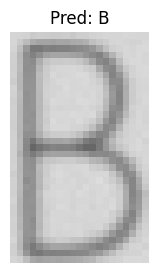

Image: 44451.png, Prédiction: B


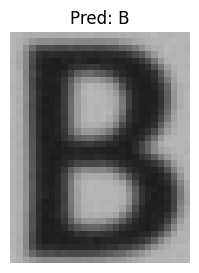

Image: 44523.png, Prédiction: B


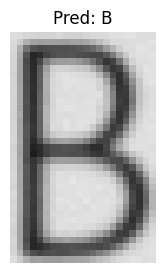

Image: 44811.png, Prédiction: B


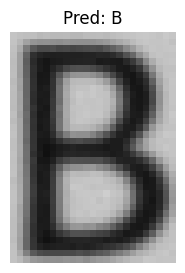

Image: 52132.png, Prédiction: O


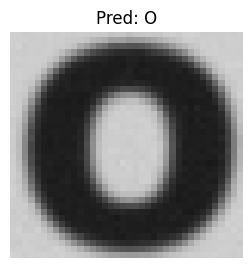

Image: 44621.png, Prédiction: 1


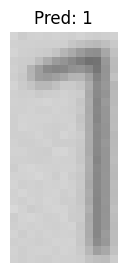

Image: 44667.png, Prédiction: B


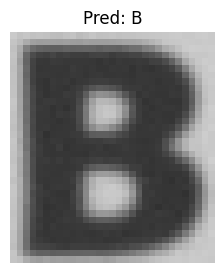

Image: 44404.png, Prédiction: 0


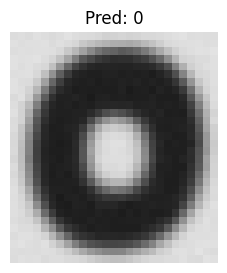


✅ Prédictions pour toutes les images du dossier terminées.


In [80]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # To display images in Colab

# Assume final_model and label_encoder are defined from previous steps.
# Assume TARGET_SIZE is defined from previous steps (e.g., TARGET_SIZE = (32, 32)).

# Define the path to the directory containing test images
test_directory_path = "/content/data_test"

# Check if the directory exists
if not os.path.isdir(test_directory_path):
    print(f"Erreur: Le dossier '{test_directory_path}' n'existe pas.")
else:
    print(f"✅ Dossier '{test_directory_path}' trouvé.")

    # Get a list of image files in the directory
    image_files = [f for f in os.listdir(test_directory_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucun fichier image trouvé dans le dossier '{test_directory_path}'.")
    else:
        print(f"✅ {len(image_files)} fichiers image trouvés dans le dossier.")
        print("\n⏳ Génération des prédictions pour chaque image...")

        # Iterate through each image file in the directory
        for filename in image_files:
            image_path = os.path.join(test_directory_path, filename)

            # Load the image using OpenCV
            image_to_test = cv2.imread(image_path, cv2.IMREAD_COLOR) # Load in color

            # Check if the image was loaded successfully
            if image_to_test is None:
                print(f"Erreur: Impossible de charger l'image '{filename}'. Skipping.")
                continue # Skip to the next image

            # --- Prepare the image for the model ---
            # Convert to grayscale
            img_gray = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)

            # Resize to the target size
            img_resized = cv2.resize(img_gray, TARGET_SIZE)

            # Normalize pixel values to [0, 1]
            img_normalized = img_resized.astype('float32') / 255.0

            # Reshape for the model (add batch dimension and channel dimension)
            img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)

            # If your model expects 3 channels (like MobileNetV2), duplicate the channel
            img_input_model = np.repeat(img_reshaped, 3, axis=-1)
            # Otherwise, use img_input_model = img_reshaped

            # --- Make a prediction using the final model ---
            prediction_probabilities = final_model.predict(img_input_model, verbose=0) # Use verbose=0 to avoid printing progress for each image

            # Get the predicted class index
            predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]

            # Get the predicted label
            predicted_label = label_encoder.classes_[predicted_class_index]

            # --- Display the image and prediction ---
            print(f"Image: {filename}, Prédiction: {predicted_label}")

            plt.figure(figsize=(3, 3)) # Adjust figure size for multiple images
            # Display the original image
            plt.imshow(cv2.cvtColor(image_to_test, cv2.COLOR_BGR2RGB))
            plt.title(f"Pred: {predicted_label}")
            plt.axis('off')
            plt.show()

            # Optional: Display prediction probabilities for this image
            # print("  Probabilités :", dict(zip(label_encoder.classes_, prediction_probabilities[0])))

        print("\n✅ Prédictions pour toutes les images du dossier terminées.")

## TEST DE RGB SUR IMAGE

The shape of the original image: (225, 225, 3)
The shape of the resized image: (32, 32, 3)


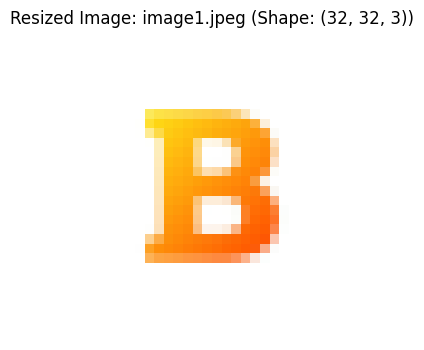

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import OpenCV for reading and processing images

# Define the path to your image file
image_path = "/content/data_rgb/image1.jpeg"

# Define the target size for resizing
target_size = (32, 32) # Width, Height

# Read the image using OpenCV
image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR) # Read in color

# Check if the image was loaded successfully
if image_rgb is None:
    print(f"Error: Could not load image from path: {image_path}")
else:
    print(f"The shape of the original image: {image_rgb.shape}")

    # --- Resize the image to the target size ---
    # Interpolation method can affect image quality. INTER_AREA is good for shrinking.
    image_resized = cv2.resize(image_rgb, target_size, interpolation=cv2.INTER_AREA)

    print(f"The shape of the resized image: {image_resized.shape}")

    # Display the resized RGB image
    plt.figure(figsize=(4, 4)) # Adjust figure size as needed

    # OpenCV reads images in BGR format, but matplotlib expects RGB.
    # Convert BGR to RGB before displaying with matplotlib
    plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

    plt.title(f"Resized Image: {os.path.basename(image_path)} (Shape: {image_resized.shape})")
    plt.axis('off') # Hide axes
    plt.show()

The shape of the original image: (225, 225, 3)
The shape of the grayscale image: (225, 225)
The shape of the resized grayscale image: (32, 32)
The shape of the resized grayscale (3-channel) image: (32, 32, 3)


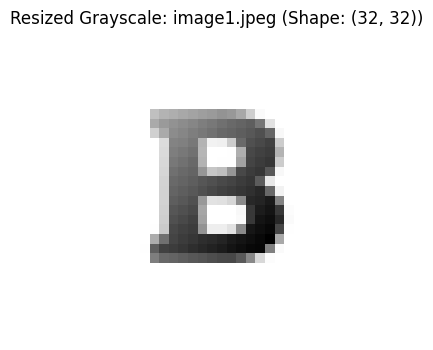

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import OpenCV for reading and processing images
import os # Import os for handling paths

# Define the path to your image file
image_path = "/content/data_rgb/image1.jpeg"

# Define the target size for resizing (32x32)
target_size = (32, 32) # Width, Height

# Read the image using OpenCV
image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR) # Read in color initially

# Check if the image was loaded successfully
if image_rgb is None:
    print(f"Error: Could not load image from path: {image_path}")
else:
    print(f"The shape of the original image: {image_rgb.shape}")

    # --- Convert the image to grayscale ---
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

    print(f"The shape of the grayscale image: {image_gray.shape}")

    # --- Resize the grayscale image to the target size ---
    # Use INTER_AREA for shrinking, INTER_LINEAR or INTER_CUBIC for other cases
    image_gray_resized = cv2.resize(image_gray, target_size, interpolation=cv2.INTER_AREA)

    print(f"The shape of the resized grayscale image: {image_gray_resized.shape}")

    # --- Convert the resized grayscale image to 3 channels (for models expecting 3 channels) ---
    # This duplicates the grayscale channel three times
    image_gray_resized_3channel = np.repeat(image_gray_resized[:, :, np.newaxis], 3, axis=-1)

    print(f"The shape of the resized grayscale (3-channel) image: {image_gray_resized_3channel.shape}")


    # Display the resized grayscale image
    plt.figure(figsize=(4, 4)) # Adjust figure size as needed
    plt.imshow(image_gray_resized, cmap='gray')
    plt.title(f"Resized Grayscale: {os.path.basename(image_path)} (Shape: {image_gray_resized.shape})")
    plt.axis('off') # Hide axes
    plt.show()


✅ Dossier de sortie 'data_gris' prêt.
📐 Dimensions de l’image originale : (225, 225, 3)
📐 Dimensions de l’image en niveaux de gris : (225, 225)
📐 Image finale avec 3 canaux : (32, 32, 3)


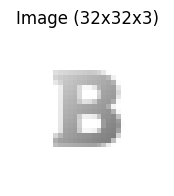

✅ Image 32x32x3 enregistrée avec succès : data_gris/image1.jpeg


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# --- Paramètres ---
image_path = "/content/data_rgb/image1.jpeg"   # Chemin vers l'image couleur
output_directory = "data_gris"                 # Répertoire de sortie pour l'image en niveaux de gris

# --- Étape 1 : Créer le dossier de sortie s’il n’existe pas ---
os.makedirs(output_directory, exist_ok=True)
print(f"✅ Dossier de sortie '{output_directory}' prêt.")

# --- Étape 2 : Lire l’image ---
image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image_rgb is None:
    print(f"❌ Erreur : l’image n’a pas pu être chargée depuis : {image_path}")
else:
    print(f"📐 Dimensions de l’image originale : {image_rgb.shape}")

    # --- Étape 3 : Conversion en niveaux de gris ---
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    print(f"📐 Dimensions de l’image en niveaux de gris : {image_gray.shape}")

    # --- Étape 4 : Redimensionner à (32, 32) ---
    image_resized = cv2.resize(image_gray, (32, 32), interpolation=cv2.INTER_AREA)

    # --- Étape 5 : Convertir en image à 3 canaux (grayscale → RGB) ---
    image_rgb_3ch = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)
    print(f"📐 Image finale avec 3 canaux : {image_rgb_3ch.shape}")  # Doit être (32, 32, 3)

    # --- Étape 6 : Affichage ---
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(image_rgb_3ch, cv2.COLOR_BGR2RGB))
    plt.title("Image (32x32x3)")
    plt.axis('off')
    plt.show()

    # --- Étape 7 : Enregistrement ---
    base_filename = os.path.basename(image_path)
    output_path = os.path.join(output_directory, base_filename)

    if cv2.imwrite(output_path, image_rgb_3ch):
        print(f"✅ Image 32x32x3 enregistrée avec succès : {output_path}")
    else:
        print(f"❌ Erreur lors de l’enregistrement de l’image sous : {output_path}")


✅ Dossier de sortie 'data_gris' prêt.
📐 Dimensions de l’image originale : (225, 225, 3)
🔍 Zoom appliqué : nouvelle taille (150, 150, 3)
📐 Image en niveaux de gris : (150, 150)
📐 Image finale avec 3 canaux : (32, 32, 3)


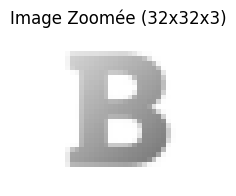

✅ Image zoomée enregistrée avec succès : data_gris/image1.jpeg


In [114]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# --- Paramètres ---
image_path = "/content/data_rgb/image1.jpeg"
output_directory = "data_gris"
zoom_factor = 1.5  # >1 = zoom avant ; ex: 1.5 = garde 2/3 de l'image

# --- Étape 1 : Créer le dossier de sortie ---
os.makedirs(output_directory, exist_ok=True)
print(f"✅ Dossier de sortie '{output_directory}' prêt.")

# --- Étape 2 : Lire l’image ---
image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image_rgb is None:
    print(f"❌ Erreur : l’image n’a pas pu être chargée depuis : {image_path}")
else:
    print(f"📐 Dimensions de l’image originale : {image_rgb.shape}")

    # --- Étape 3 : Appliquer un zoom central ---
    h, w, _ = image_rgb.shape
    new_w = int(w / zoom_factor)
    new_h = int(h / zoom_factor)
    x1 = (w - new_w) // 2
    y1 = (h - new_h) // 2
    image_zoomed = image_rgb[y1:y1+new_h, x1:x1+new_w]
    print(f"🔍 Zoom appliqué : nouvelle taille {image_zoomed.shape}")

    # --- Étape 4 : Conversion en niveaux de gris ---
    image_gray = cv2.cvtColor(image_zoomed, cv2.COLOR_BGR2GRAY)
    print(f"📐 Image en niveaux de gris : {image_gray.shape}")

    # --- Étape 5 : Redimensionner à (32, 32) ---
    image_resized = cv2.resize(image_gray, (32, 32), interpolation=cv2.INTER_AREA)

    # --- Étape 6 : Convertir en image à 3 canaux (grayscale → RGB) ---
    image_rgb_3ch = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)
    print(f"📐 Image finale avec 3 canaux : {image_rgb_3ch.shape}")

    # --- Étape 7 : Affichage ---
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(image_rgb_3ch, cv2.COLOR_BGR2RGB))
    plt.title("Image Zoomée (32x32x3)")
    plt.axis('off')
    plt.show()

    # --- Étape 8 : Enregistrement ---
    base_filename = os.path.basename(image_path)
    output_path = os.path.join(output_directory, base_filename)

    if cv2.imwrite(output_path, image_rgb_3ch):
        print(f"✅ Image zoomée enregistrée avec succès : {output_path}")
    else:
        print(f"❌ Échec de l’enregistrement de l’image.")


✅ Dossier de sortie 'data_gris' prêt.
📐 Dimensions de l’image originale : (225, 225, 3)
🔍 Zoom appliqué : nouvelle taille (150, 150, 3)
📐 Image finale : (32, 32, 3)


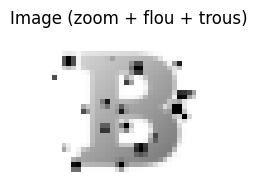

✅ Image augmentée enregistrée : data_gris/aug1_image1.jpeg


In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random

# --- Paramètres ---
image_path = "/content/data_rgb/image1.jpeg"
output_directory = "data_gris"
zoom_factor = 1.5  # zoom central
num_holes = 20       # nombre de trous à ajouter
max_hole_size = 12   # taille maximale des trous (pixels)

# --- Étape 1 : Créer le dossier de sortie ---
os.makedirs(output_directory, exist_ok=True)
print(f"✅ Dossier de sortie '{output_directory}' prêt.")

# --- Étape 2 : Lire l’image ---
image_rgb = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image_rgb is None:
    print(f"❌ Erreur : l’image n’a pas pu être chargée depuis : {image_path}")
else:
    print(f"📐 Dimensions de l’image originale : {image_rgb.shape}")

    # --- Étape 3 : Zoom central ---
    h, w, _ = image_rgb.shape
    new_w = int(w / zoom_factor)
    new_h = int(h / zoom_factor)
    x1 = (w - new_w) // 2
    y1 = (h - new_h) // 2
    image_zoomed = image_rgb[y1:y1+new_h, x1:x1+new_w]
    print(f"🔍 Zoom appliqué : nouvelle taille {image_zoomed.shape}")

    # --- Étape 4 : Flou gaussien ---
    image_blurred = cv2.GaussianBlur(image_zoomed, (5, 5), 0)

    # --- Étape 5 : Conversion en niveaux de gris ---
    image_gray = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2GRAY)

    # --- Étape 6 : Ajouter des trous (zones noires aléatoires) ---
    for _ in range(num_holes):
        hole_size = random.randint(2, max_hole_size)
        x = random.randint(0, image_gray.shape[1] - hole_size)
        y = random.randint(0, image_gray.shape[0] - hole_size)
        image_gray[y:y+hole_size, x:x+hole_size] = 0  # trou noir

    # --- Étape 7 : Redimensionner à (32, 32) ---
    image_resized = cv2.resize(image_gray, (32, 32), interpolation=cv2.INTER_AREA)

    # --- Étape 8 : Convertir en 3 canaux (RGB) ---
    image_rgb_3ch = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2BGR)
    print(f"📐 Image finale : {image_rgb_3ch.shape}")

    # --- Étape 9 : Affichage ---
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(image_rgb_3ch, cv2.COLOR_BGR2RGB))
    plt.title("Image (zoom + flou + trous)")
    plt.axis('off')
    plt.show()

    # --- Étape 10 : Enregistrement ---
    base_filename = os.path.basename(image_path)
    output_path = os.path.join(output_directory, "aug1_" + base_filename)

    if cv2.imwrite(output_path, image_rgb_3ch):
        print(f"✅ Image augmentée enregistrée : {output_path}")
    else:
        print(f"❌ Échec de l’enregistrement de l’image.")


✅ Image chargée avec succès.
📐 Dimensions finales : (32, 32, 3)


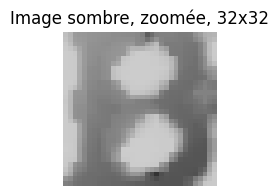

✅ Image enregistrée avec succès : /content/data_gris/processed_aug1_image1.jpeg


In [132]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Paramètres ---
input_path = "/content/data_gris/aug1_image1.jpeg"
output_path = "/content/data_gris/processed_aug1_image1.jpeg"

# --- Chargement de l’image ---
image = cv2.imread(input_path)
if image is None:
    print(f"❌ Impossible de charger l’image depuis : {input_path}")
else:
    print("✅ Image chargée avec succès.")

    # --- Filtre médian (réduction du bruit) ---
    image_median = cv2.medianBlur(image, 3)

    # --- Dilatation (combler les trous) ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_dilated = cv2.dilate(image_median, kernel, iterations=1)

    # --- Réduction de la luminosité ---
    hsv = cv2.cvtColor(image_dilated, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.subtract(v, 50)  # 🔅 Assombrit l’image (attention à ne pas dépasser < 0)
    v = np.clip(v, 0, 255)
    dark_hsv = cv2.merge((h, s, v))
    image_dark = cv2.cvtColor(dark_hsv, cv2.COLOR_HSV2BGR)

    # --- Zoom simulé (recadrage central puis resize) ---
    height, width = image_dark.shape[:2]
    crop_size = int(min(height, width) * 0.6)  # Zoom sur ~60% de l'image centrale
    start_x = width // 2 - crop_size // 2
    start_y = height // 2 - crop_size // 2
    image_zoomed = image_dark[start_y:start_y + crop_size, start_x:start_x + crop_size]

    # --- Redimensionnement à (32, 32) ---
    image_final = cv2.resize(image_zoomed, (32, 32), interpolation=cv2.INTER_AREA)
    print(f"📐 Dimensions finales : {image_final.shape}")  # (32, 32, 3)

    # --- Affichage de l’image résultante ---
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB))
    plt.title("Image sombre, zoomée, 32x32")
    plt.axis('off')
    plt.show()

    # --- Enregistrement ---
    success = cv2.imwrite(output_path, image_final)
    if success:
        print(f"✅ Image enregistrée avec succès : {output_path}")
    else:
        print("❌ Erreur lors de l’enregistrement.")


✅ Image chargée avec succès.


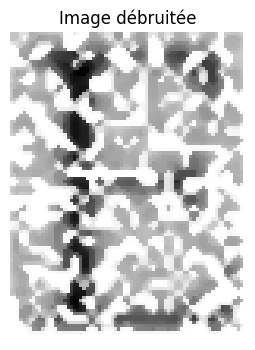

✅ Image débruitée enregistrée avec succès : /content/data_gris/E_denoised.png


In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Paramètres ---
input_path = "/content/data_rgb/imageE.png"
output_path = "/content/data_gris/E_denoised.png"

# --- Chargement de l’image ---
image = cv2.imread(input_path)
if image is None:
    print(f"❌ Impossible de charger l’image depuis : {input_path}")
else:
    print("✅ Image chargée avec succès.")

    # --- Filtre médian (réduction du bruit) ---
    image_denoised = cv2.medianBlur(image, 3)

    # --- Affichage de l’image débruitée ---
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(image_denoised, cv2.COLOR_BGR2RGB))
    plt.title("Image débruitée")
    plt.axis('off')
    plt.show()

    # --- Enregistrement ---
    success = cv2.imwrite(output_path, image_denoised)
    if success:
        print(f"✅ Image débruitée enregistrée avec succès : {output_path}")
    else:
        print("❌ Erreur lors de l’enregistrement.")


✅ Dossier '/content/data_gris' trouvé.
✅ 7 fichiers image trouvés dans le dossier.

⏳ Génération des prédictions pour chaque image...
Image: imageE.png, Prédiction: E


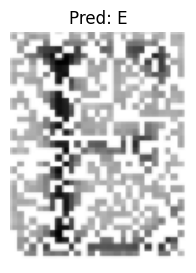

Image: aug_image1.jpeg, Prédiction: B


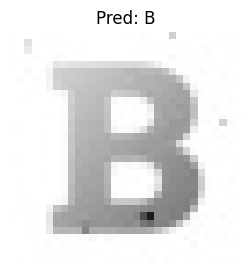

Image: image1.jpeg, Prédiction: 0


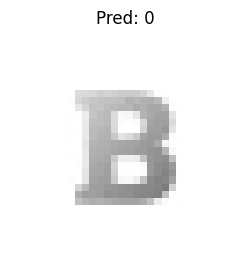

Image: E_denoised.png, Prédiction: E


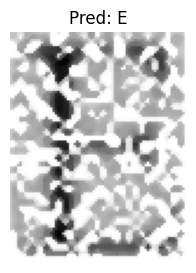

Image: E.png, Prédiction: 4


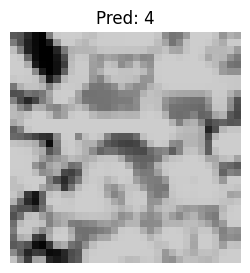

Image: aug1_image1.jpeg, Prédiction: 3


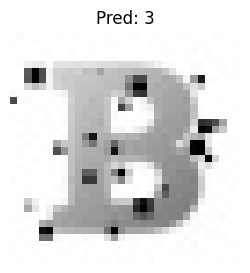

Image: processed_aug1_image1.jpeg, Prédiction: B


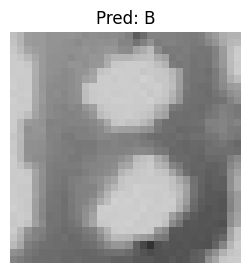


✅ Prédictions pour toutes les images du dossier terminées.


In [140]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # To display images in Colab

# Assume final_model and label_encoder are defined from previous steps.
# Assume TARGET_SIZE is defined from previous steps (e.g., TARGET_SIZE = (32, 32)).

# Define the path to the directory containing test images
test_directory_path = "/content/data_gris"

# Check if the directory exists
if not os.path.isdir(test_directory_path):
    print(f"Erreur: Le dossier '{test_directory_path}' n'existe pas.")
else:
    print(f"✅ Dossier '{test_directory_path}' trouvé.")

    # Get a list of image files in the directory
    image_files = [f for f in os.listdir(test_directory_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucun fichier image trouvé dans le dossier '{test_directory_path}'.")
    else:
        print(f"✅ {len(image_files)} fichiers image trouvés dans le dossier.")
        print("\n⏳ Génération des prédictions pour chaque image...")

        # Iterate through each image file in the directory
        for filename in image_files:
            image_path = os.path.join(test_directory_path, filename)

            # Load the image using OpenCV
            image_to_test = cv2.imread(image_path, cv2.IMREAD_COLOR) # Load in color

            # Check if the image was loaded successfully
            if image_to_test is None:
                print(f"Erreur: Impossible de charger l'image '{filename}'. Skipping.")
                continue # Skip to the next image

            # --- Prepare the image for the model ---
            # Convert to grayscale
            img_gray = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)

            # Resize to the target size
            img_resized = cv2.resize(img_gray, TARGET_SIZE)

            # Normalize pixel values to [0, 1]
            img_normalized = img_resized.astype('float32') / 255.0

            # Reshape for the model (add batch dimension and channel dimension)
            img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)

            # If your model expects 3 channels (like MobileNetV2), duplicate the channel
            img_input_model = np.repeat(img_reshaped, 3, axis=-1)
            # Otherwise, use img_input_model = img_reshaped

            # --- Make a prediction using the final model ---
            prediction_probabilities = final_model.predict(img_input_model, verbose=0) # Use verbose=0 to avoid printing progress for each image

            # Get the predicted class index
            predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]

            # Get the predicted label
            predicted_label = label_encoder.classes_[predicted_class_index]

            # --- Display the image and prediction ---
            print(f"Image: {filename}, Prédiction: {predicted_label}")

            plt.figure(figsize=(3, 3)) # Adjust figure size for multiple images
            # Display the original image
            plt.imshow(cv2.cvtColor(image_to_test, cv2.COLOR_BGR2RGB))
            plt.title(f"Pred: {predicted_label}")
            plt.axis('off')
            plt.show()

            # Optional: Display prediction probabilities for this image
            # print("  Probabilités :", dict(zip(label_encoder.classes_, prediction_probabilities[0])))

        print("\n✅ Prédictions pour toutes les images du dossier terminées.")